<a href="https://colab.research.google.com/github/fersondahl/MercadoBr_Atacantes/blob/main/MVP_Sprint_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

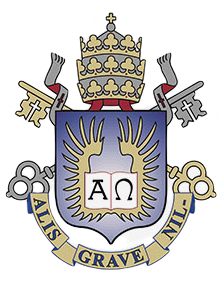

# **PUC - RIO**
---
#### Sprint: Machine Learning & Analytics
#### Autor: Fernando Söndahl Brito

#0. Introdução e Contexto

O estudo a seguir tem fins acadêmicos que envolvem a adoção de técnicas de RPA, tratamento e pré processamento de dados, além da implementação de modelos de *Machine Learning*.

> O trabalho tem como principal objetivo definir um **Modelo de Regressão** capaz de definir o valor de Mercado de diferentes jogadores de futebol a partir de suas estatísticas de desempenho e informações pessoais.

> O estudo vislumbra gerar uma ferramenta capaz de apoiar o trabalho de *Scouts* na atividade de mapeamento do mercado. Espera-se que os resultados gerados pelo modelo sejam capazes de indicar oportunidades de mercado para um grupo de jogadores que produzem mais em campo do que estão avaliados (Subvalorizados); E por outro lado, apontar jogadores que estão na situação contrária, produzem menos do que estão avaliados, e podem apresentar um investimento de maior risco.

> Todas as informações coletadas para o modelo foram retirados do [Sofascore](https://www.sofascore.com/pt/), um dos principais portais de estatísticas esportativas do mundo. Desde as informações pessoais dos jogadores, estatísticas e o próprio valor de mercado foram retirados do Sofascore.

> Como os valores de mercado dos jogadores são conhecidos a partir do Sofascore, e é justamente o *target* da aplicação, os modelos serão gerados através do **aprendizado supervisionado**.

> A realização do estudo estará centrada no desempenho dos atletas no Campeonato Brasileiro de 2023, por tanto, serão consideradas apenas estatísticas realizadas na própria competição. Isso evita que atletas que participaram de competições de nível inferior tenham suas estatísticas beneficiadas, como no caso da diferença de nível entre diferentes campeonatos estaduais e a participação em copas internacionais.

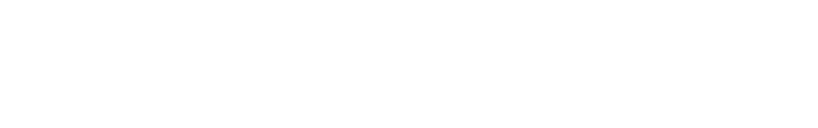

#1. Ingestão de dados do *SofaScore*

> Sem sucesso em obter acesso à API para que o fluxo de dados pudesse ser realizado de maneira mais estruturada, a solução possível para se obter os dados do Sofascore é utilizar técnicas de *Web Scrapping*.

> A primeira opção foi se fazer uso de requisições do protocolo HTTP para obter as informações contidas no *site*, em que a técnica poderia ser implementada através da biblioteca [Requests](https://requests.readthedocs.io/projects/pt/pt-br/latest/). Contudo, ao consultar os documentos de uso do Sofascore fica vedada a utilização desse tipo de abordagem ([Sofascore/robots.txt](https://www.sofascore.com/robots.txt)). Dessa maneira, essa alternativa foi também descartada.

> A opção de retirada manual dos dados é viável do ponto de vista técnico, mas inviável no sentido prático, em que se necessita um volume grande de informações para a implementação dos modelos. Com isso, a alternativa elegida foi se desenvolver uma solução RPA que simula a utilização da plataforma por um humano, através de um robô automatizado.

> Por conta do tempo de execução e possibilidade de erros por incompatibilidade de *drivers*, a execução dos códigos não será realizada nesse *notebook*. De toda maneira, o resultado dos dados gerados a partir dos scripts expostos na íntegra podem ser consultados no Github, nos mesmos arquivos que serão utilizados na sequência do trabalho.

## 1.1 Coleta do URL da homepage dos Jogadores

> O primeiro passo foi desenvolver um robô que coletasse o maior número possível de jogadores que estivessem alinhados aos critérios do estudo. No *homepage* do campeonato do Sofascore é possível selecionar a temporada de 2023, ordenar os jogadores por melhores estatísticas de ataque e extrair suas informações.

> O robô lê a tabela de jogadores e extrai a informação dos 20 atletas exibidas. Ao todo o robô itera por 30 páginas, e coleta a informação de 600 jogadores.

> As informações coletadas são:
>1.   Nome do Atleta
>2.   Equipe a que pertence
>3.   URL da sua página no sofascore

Da página principal de cada atleta serão posteriormente extraídas as suas estatísticas.



```

## PACOTES
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

import pandas as pd

import time

service = Service(executable_path="chromedriver.exe")
driver = webdriver.Chrome(service=service)

## INICIA O DRIVER NO HOMEPAGE DO CAMPEONATO BRASILEIRO
driver.get("https://www.sofascore.com/pt/torneio/futebol/brazil/brasileirao-serie-a/325#id:58766")

driver.maximize_window()


## CLICA NO COMBOBOX PARA ALTERAR O ANO
WebDriverWait(driver, 5).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, 'div.sc-jEACwC.dFmUba')))

combos = driver.find_element(By.CSS_SELECTOR, 'div.sc-jEACwC.dFmUba').find_elements(
    By.TAG_NAME, 'button')


combos[0].click()

ano_selec = driver.find_element(By.CSS_SELECTOR, 'div.Box.sc-dAlyuH.fmYWCR.kIVNDl'
                                ).find_elements(By.TAG_NAME, "li")

trat_options = list(map(lambda elem: str(elem.text), ano_selec))

## SELECIONA O ANO DE 2023
try:
    ano_selec[trat_options.index('2023')].click()
except ValueError:
    driver.close()

time.sleep(5)

WebDriverWait(driver, 5).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, 'div.Box.biPAua')))


## SELECIONA PARA MOSTRAR AS ESTATÍSTICAS COM FOCO EM ATACANTES
selc_atacantes = driver.find_element(By.CSS_SELECTOR, 'div.Box.biPAua').find_element(
    By.XPATH, "//*[contains(text(), 'Ataque')]")
selc_atacantes.click()


players = pd.DataFrame()

## LOOP PARA LER OS DADOS DOS REGISTROS EXIBIDOS E PASSAR PARA A PRÓXIMA PÁGINA DE ATLETAS
for i in range(30):
    WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "table.sc-75bb9fa3-8.lnrjHE")))

    ## ENCONTRA O ELEMENTO DA TABELA DE JOGADORES
    tabela = driver.find_element(By.CSS_SELECTOR, "table.sc-75bb9fa3-8.lnrjHE")

    ## SELECIONA TODOS OS REGISTROS DE JOGADORES
    jogadores = tabela.find_elements(By.TAG_NAME, 'tr')


    ## EXTRAI A EQUIPE DE CADA JOGADOR
    equipe = list(map(lambda elem: elem.find_element(By.CSS_SELECTOR, 'td.sc-75bb9fa3-3.iwffCj').get_attribute('title'),
            jogadores[1:]))


    ## EXTRAI O NOME E A URL DA PÁGINA DE CADA JOGADOR
    player_url = list(map(lambda elem: elem.find_element(By.CSS_SELECTOR, 'td.sc-75bb9fa3-5.kajgok'),
            jogadores[1:]))


    player_url = list(map(lambda elem: {elem.text:elem.find_element(By.TAG_NAME, 'a').get_attribute('href')},
            player_url))

    ## CRIA DATAFRAME COM OS DADOS DOS JOGADORES LIDOS NA PÁGINA
    page_players = pd.DataFrame([
        list(map(lambda elem: list(elem.keys())[0], player_url)),
        list(map(lambda elem: list(elem.values())[0], player_url)),
        equipe], index=['player', 'player_url', 'equipe']).T

    ## CONCATENA TODOS OS JOGADORES LIDOS EM ÚNICO DATAFRAME
    players = pd.concat([players, page_players], axis=0)

    next_page = driver.find_elements(By.CSS_SELECTOR, 'button.Button.llwjsV')[-1]

    ## CLICA NO BOTÃO PARA PASSAR PARA A PRÓXIMA PÁGINA
    next_page.click()


driver.close()

## CRIA COLUNA COM O ID SOFASCORE DO JOGADOR
players['player_id'] = players['player_url'].apply(lambda linha: int(linha.split("/")[-1]))


## EXPORTA PARQUET COM OS DADOS COLETADOS
players.to_parquet("br players.parquet",
                   engine='pyarrow', compression='gzip', index=False)


```

Um vídeo de exemplo da operação do robô pode ser consultado em [Robot Sofascore](https://github.com/fersondahl/MercadoBr_Atacantes/raw/main/Robot%20Sofascore.mp4)

[```players``` no GitHub](https://github.com/fersondahl/MercadoBr_Atacantes/blob/0fe3289b9f1ebb706902e00ff80fbb669fd57503/br%20players.parquet)

## 1.2 Coleta das Estatísticas e informações dos Jogadores selecionados

> Com os jogadores já definidos, um segundo robô é desenvolvido para que sejam extraídas suas estatísticas.

> O robô primeiro seleciona a competição, sendo o Brasileirão e depois a temporada de 2023.


> Em sequência, o robô extrai de um só fez todas as estatísticas de jogo, depois as informações pessoais do atleta e por último seu valor de mercado.

> Todo o processo de consulta, utilização do site e extração dos dados é feita separadamente para cada atleta. Todo o processo está contido na *Function* ``` get_player_stats```, que é chamada iterativamente para cada jogador.

```

## FUNC PARA EXTRAIR INFORMAÇÕES E ESTATÍSTICAS DE CADA JOGADOR
def get_player_stats(player_home_url):
    service = Service(executable_path=rchromedriver.exe")
    driver = webdriver.Chrome(service=service)

    ## É FEITA A NAVEGAÇÃO PARA A PÁGINA DO JOGADOR, ATRAVÉS DO URL PASSADO COMO PARÂMETRO DA FUNÇÃO
    driver.get(player_home_url)

    driver.maximize_window()


    ## SELEÇÃO DO COMBOBOX QUE DEFINE O CAMPEONATO DAS ESTATÍSTICAS EXIBIDAS
    WebDriverWait(driver, 25).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.Box.gjbyaX')))

    combos = driver.find_element(By.CSS_SELECTOR, 'div.Box.gjbyaX').find_elements(
        By.TAG_NAME, 'button')


    combos[0].click()

    camp = driver.find_element(By.CSS_SELECTOR, 'div.Box.sc-dAlyuH.fmYWCR.kIVNDl').find_elements(
        By.TAG_NAME, "li")

    trat_options = list(map(lambda elem: elem.text, camp))

    ## SELECIONA O BRASILEIRÃO SÉRIE A
    try:
        camp[trat_options.index('Brasileirão Série A')].click()
    except ValueError:
        driver.close()
        return


    ## SELEÇÃO DO COMBOBOX QUE DEFINE A TEMPORADA
    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.Box.gjbyaX')))

    combos[1].click()

    ano_selec = driver.find_element(By.CSS_SELECTOR, 'div.Box.sc-dAlyuH.fmYWCR.kIVNDl'
                                    ).find_elements(By.TAG_NAME, "li")

    trat_options = list(map(lambda elem: str(elem.text), ano_selec))

    ## SELECIONA O ANO DE 2023
    try:
        ano_selec[trat_options.index('2023')].click()
    except ValueError:
        driver.close()
        return

    ## SELECIONA A DIV ONDE ESTÃO TODAS AS ESTATÍSTICAS
    look_stats= 'div.Box.Flex.dlyXLO.bnpRyo'

    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, look_stats)))


    busca = driver.find_elements(By.CSS_SELECTOR, look_stats)

    ## SEPARA O TÍTULO DAS ESTATÍSTAS E SEUS VALORES, DEPOIS OS COMBINA EM FORMATO DE DICIONÁRIO
    stats = list(map(lambda elem: elem.text.split("\n"), busca))
    stats = dict(zip(list(map(lambda elem: elem[0], stats)), list(map(lambda elem: elem[1], stats))))


    ## SELECIONA A DIV ONDE ESTÃO AS INFORMAÇÕES PESSOAIS DOS JOGADORES
    look_infos = 'div.Box.Flex.ggRYVx.kpyaMP'

    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, look_infos)))


    busca = driver.find_element(By.CSS_SELECTOR, look_infos)

    ## TRATAMENTO DO PADRÃO DE CONSOLIDAÇÃO DAS INFORMAÇÕES
    infos = busca.text.split("\n")

    cabec = pd.Series(infos)[list(range(0, len(infos), 2))].to_list()

    registros = pd.Series(infos)[list(range(1, len(infos), 2))].to_list()

    if 'anos' in registros[1]:
        registros[1], cabec[1] = cabec[1], 'NASCIMENTO'

    infos = dict(zip(cabec, registros))

    ## SELECIONA DIV ONDE ESTÁ O VALOR DE MERCADO DO JOGADOR
    look_price = 'div.Box.cNWmcN'

    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, look_price)))

    busca = driver.find_element(By.CSS_SELECTOR, look_price)

    try:
        price = busca.text.split("\n")[1]
    except IndexError:
        driver.close()
        return

    driver.close()

    return stats, infos, price
#%%

## GERA O DATAFRAME ONDE ESTÃO ARMAZENADOS OS JOGADORES COLETADOS ANTERIORMENTE COM SEUS URLS
players = pd.read_parquet(
    r"https://github.com/fersondahl/MercadoBr_Atacantes/raw/main/br%20players.parquet")

players_stats = {}


## É ACESSADA ITERATIVAMENTE A PÁGINA DE CADA JOGADOR E SUAS INFORMAÇÕES/ESTATÍSTICAS SÃO COLETADAS
for ind, player in players.iterrows():
    try:
        sts, inf, prc = get_player_stats(player['player_url'])
        players_stats.update({player['player_id']:{'Estatísticas':sts, 'Informações':inf, 'Preço':prc}})
    except TypeError:
        pass

players_stats = pd.DataFrame.from_dict(players_stats, orient='index').rename_axis('player_id').reset_index()

## GERA ARQUIVO COM AS DADOS CONSOLIDADOS DOS JOGADORES
result_stats = pd.merge(left=players, right=players_stats, on='player_id', how='inner')

result_stats.to_parquet("br players stats.parquet",
                    engine='pyarrow', compression='gzip', index=False)



```

[```player_stats``` no GitHub](https://github.com/fersondahl/MercadoBr_Atacantes/blob/0fe3289b9f1ebb706902e00ff80fbb669fd57503/br%20players%20stats.parquet)

#2. Conexão e Tratamento dos dados

##2.0 Bibliotecas

In [29]:
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import re
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

##2.1 Importação dos dados do GitHub:

In [30]:
## IMPORTAÇÃO DOS DADOS DOS JOGADORES DO BRASILEIRÃO 2024
pl_stats = pd.read_parquet("https://github.com/fersondahl/MercadoBr_Atacantes/raw/main/br%20players%20stats.parquet")

## TRANSFORMAÇÃO DOS DADOS DE PREÇO PARA MILHÕES DE EUROS
pl_stats['Preço'] = pl_stats['Preço'].apply(lambda elem: float(elem.split("M")[0]) if "M" in elem
                        else float(elem.split("K")[0])/1e3)

pl_stats = pl_stats.rename(columns={'Preço': 'value_M'})


pl_stats

,player,player_url,equipe,player_id,Estatísticas,Informações,value_M
0,Paulinho,https://www.sofascore.com/pt/jogador/paulinho/...,Atlético Mineiro,885179,"{'Amarelo': '3', 'Assistências': '2', 'Assistê...","{'ALTURA': '175 cm', 'NACIONALIDADE': 'BRA', '...",14.500
1,Luis Suárez,https://www.sofascore.com/pt/jogador/luis-suar...,Grêmio,16943,"{'Amarelo': '8', 'Assistências': '11', 'Assist...","{'ALTURA': '182 cm', 'NACIONALIDADE': 'URU', '...",3.600
2,Tiquinho Soares,https://www.sofascore.com/pt/jogador/tiquinho-...,Botafogo,789100,"{'Amarelo': '10', 'Assistências': '4', 'Assist...","{'ALTURA': '187 cm', 'NACIONALIDADE': 'BRA', '...",3.100
3,Hulk,https://www.sofascore.com/pt/jogador/hulk/34705,Atlético Mineiro,34705,"{'Amarelo': '8', 'Assistências': '11', 'Assist...","{'ALTURA': '180 cm', 'NACIONALIDADE': 'BRA', '...",2.200
4,Marcos Leonardo,https://www.sofascore.com/pt/jogador/marcos-le...,Santos,1047227,"{'Amarelo': '3', 'Assistências': '2', 'Assistê...","{'ALTURA': '174 cm', 'NACIONALIDADE': 'BRA', '...",26.000
...,...,...,...,...,...,...,...
561,Sandry,https://www.sofascore.com/pt/jogador/sandry/97...,Santos,973847,"{'Amarelo': '2', 'Assistências': None, 'Assist...","{'ALTURA': '173 cm', 'NACIONALIDADE': 'BRA', '...",3.900
562,Manoel,https://www.sofascore.com/pt/jogador/manoel/84845,Fluminense,84845,"{'Amarelo': '1', 'Assistências': None, 'Assist...","{'ALTURA': '182 cm', 'NACIONALIDADE': 'BRA', '...",0.325
563,Lucca,https://www.sofascore.com/pt/jogador/lucca/119...,Internacional,1199435,"{'Amarelo': '2', 'Assistências': '1', 'Assistê...","{'ALTURA': '180 cm', 'NACIONALIDADE': 'BRA', '...",1.100
564,Matheus Dias,https://www.sofascore.com/pt/jogador/dias-math...,Internacional,1020610,"{'Amarelo': '5', 'Assistências': None, 'Assist...","{'ALTURA': '187 cm', 'NACIONALIDADE': 'BRA', '...",2.200


##2.2 Tratamento das Estatísticas de jogo dos jogadores

> Uma grande quantidade de estatísticas puderam ser importadas através do Sofascore, mas é necessário tratá-las para que estejam no padrão de tipagem correto para o modelo.

> Uma boa parte dos dados podem ser diretamente convertidos para dados númericos sem que hajam erros, sendo os que traduzem dados absolutos de performance.

> Foi avaliado que um conjunto de registros apresentavam as estatísticas tanto absolutas quanto em percentual de participação dos atletas (performance por jogo). Nesses casos foi dada preferência pelas estatísticas percentuais, e foram passadas para o padrão numérico (*float*).

> Avaliando o restante de *features* ainda não tratadas chegou-se a conclusão que entre as poucas que restavam não haveria relação forte com o objetivo do trabalho, e foram então descartadas. Foram mantidas 59 das 67 estatísticas disponíveis após o tratamento.

In [31]:
## Tratamento dos dados de performance (estatísticas)

stats_cols = pl_stats['Estatísticas'].apply(pd.Series)

## DADOS NUMÉRICOS ABSOLUTOS
numeric_stats = stats_cols.fillna(0).apply(
    lambda col: pd.to_numeric(col, errors='coerce'), axis=1).dropna(axis=1)


percent_stats = stats_cols.copy().drop(numeric_stats.columns.to_list(), axis=1)

## REGISTROS QUE CONTENHAM DADOS TANTO ABSOLUTOS QUANTO PERCENTUAIS, É FEITA A SELEÇÃO DOS PERCENTUAIS
percents = percent_stats.fillna("-").apply(lambda elem: pd.Series(elem).apply(
    lambda linha: re.search(r"\((.*?)\)", linha)
        ),

    axis=1).dropna(axis=1, thresh=1)


percents = percents.apply(lambda col: pd.Series(col).apply(lambda linha: pd.NA if linha == None else float(
    linha[1].replace("%", ""))/100))

## CONSOLIDAÇÃO DOS DADOS ABSOLUTOS+PERCENTUAIS
dados_performance = pd.concat([numeric_stats, percents], axis=1)

dados_performance

,Amarelo,Assistências,Assistências Esperadas (xA),Ações com a bola,Bolas recuperadas,Bolas recuperadas por jogo,Cartões vermelhos,Chutes no gol por partida,Chutes realizados por jogo,Cortes por jogo,...,Defesas por jogo,Disputas de bola vencidas,Dribles certos,Duelos aéreos ganhos,Duelos ganhos no chão,Passes certos cavados,Passes certos no terço final,Passes certos por partida,Passes no próprio campo,Saídas certas por jogo
0,3.0,2.0,2.84,43.2,0.6,4.6,0.0,1.3,2.5,0.5,...,NaN,0.48,0.53,0.44,0.49,0.67,0.81,0.83,0.84,NaN
1,8.0,11.0,6.64,47.8,0.6,2.2,0.0,1.7,3.9,0.2,...,NaN,0.46,0.40,0.42,0.48,0.57,0.66,0.72,0.84,NaN
2,10.0,4.0,2.26,34.9,0.6,2.7,0.0,1.0,2.5,0.9,...,NaN,0.52,0.60,0.52,0.51,0.66,0.65,0.71,0.87,NaN
3,8.0,11.0,6.26,52.9,0.6,2.3,2.0,1.4,3.6,1.1,...,NaN,0.48,0.55,0.42,0.49,0.45,0.61,0.72,0.89,NaN
4,3.0,2.0,1.93,26.2,0.4,1.5,0.0,1.0,2.6,0.8,...,NaN,0.41,0.44,0.30,0.47,0.73,0.66,0.75,0.93,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,2.0,0.0,0.08,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.41,1.00,0.00,0.43,0.59,0.68,0.86,0.96,NaN
562,1.0,0.0,0.03,40.8,0.2,0.0,0.0,0.0,0.0,2.3,...,NaN,0.43,1.00,0.20,0.64,0.73,0.92,0.92,0.92,NaN
563,2.0,1.0,0.14,11.7,0.3,0.9,1.0,0.2,0.6,0.1,...,NaN,0.39,0.62,0.22,0.49,0.00,0.67,0.72,0.74,NaN
564,5.0,0.0,0.21,20.6,0.1,1.7,0.0,0.0,0.1,0.5,...,NaN,0.49,0.63,0.64,0.43,0.60,0.65,0.77,0.88,NaN


##2.3 Tratamento das infoirmações pessoais dos jogadores

> Foram tratadas também as informações pessoais dos jogadores, e calcula a idade em anos completos de cada atleta a partir de sua data de nascimento. A idade, diferente das demais informações, entende-se a priori como uma informação extremamente relevante para a definição do valor de mercado do jogador.

In [32]:
## TRATAMENTO DOS DADOS DE INFORMAÇÃO

info_cols = pl_stats['Informações'].apply(pd.Series)

## ALTURA NO PADRÃO EM METROS
info_cols['ALTURA'] = info_cols['ALTURA'].apply(lambda linha: float(linha.split(" ")[0])/100)

MESES = {'JAN.':"01", 'FEV.':"02", 'MAR.':"03", 'ABR.':"04", 'MAI.':"05", 'JUN.':"06", 'JUL.':"07",
    'AGO.':"08", 'SET.':"09", 'OUT.':"10", 'NOV.':"11", 'DEZ.':"12"}
pattern = '|'.join(sorted(re.escape(k) for k in MESES))

## TRANSFORMAÇÃO DA DATA DE NASCIMENTO EM DATETIME
info_cols['NASCIMENTO'] = info_cols['NASCIMENTO'].apply(lambda linha: re.sub(pattern, lambda elem: MESES.get(elem.group(0).upper()),
    linha, flags=re.IGNORECASE))

info_cols['NASCIMENTO'] = info_cols['NASCIMENTO'].apply(lambda linha: datetime.strptime(linha, "%d DE %m DE %Y"))


## CÁLCULO DA IDADE DO ATLETA EM DIAS E ANOS COMPLETOS
info_cols['IDADE_DIAS'] = info_cols['NASCIMENTO'].apply(lambda linha: pd.Timestamp(date.today()) - linha).dt.days

info_cols['IDADE_ANOS'] = info_cols['NASCIMENTO'].apply(lambda linha: relativedelta(date.today(), linha).years)

info_cols.columns = list(map(lambda col: col.lower(), info_cols.columns))

info_cols


,altura,nacionalidade,nascimento,número da camisa,posição,pé preferido,idade_dias,idade_anos
0,1.75,BRA,2000-07-15,10,F,Direito,8687,23
1,1.82,URU,1987-01-24,9,F,Direito,13608,37
2,1.87,BRA,1991-01-17,9,F,Direito,12154,33
3,1.80,BRA,1986-07-25,7,F,Esquerdo,13791,37
4,1.74,BRA,2003-05-02,36,F,Direito,7666,20
...,...,...,...,...,...,...,...,...
561,1.73,BRA,2002-08-30,6,M,Direito,7911,21
562,1.82,BRA,1990-02-26,26,D,Direito,12479,34
563,1.80,BRA,2003-04-02,45,F,Direito,7696,21
564,1.87,BRA,2002-05-09,41,M,Direito,8024,21


##2.3 Compilação dos registros

> Tratadas as estatísticas e informações pessoas são compiladas e apresentadas como registros de cada jogador.

> É calculada também a taxa de atualização do atleta, baseada em quantos minutos jogados no total de minutos disponíveis nas partidas disputadas. Por mais que minimize os efeitos de jogos em que o atleta não foi utilizado por opção técnica, mede a participação em jogos que o jogador esteve efetivamente disponível para jogo. Além da opção técnica, pode-se suprimir os efeitos de não utilização por lesão e suspensão que indiferem da qualidade do atleta.

> Entende-se que a métrica gera um valor importante para se entender a importancia do atleta dentro do elenco.

In [33]:
## CONSOLIDAÇÃO DOS DADOS DOS ATLETAS
cmp_stats = pd.concat([pl_stats.drop(['Estatísticas', 'Informações'], axis=1),
                       info_cols, dados_performance], axis=1)


## EXCLUSÃO DE ESTATÍSTICAS REDUNDANTES POR JOGO/TOTAL
filt_redundante = list(map(lambda elem: elem.replace("por jogo", "").strip(),
         list(filter(lambda col: "por jogo" in col.lower(), cmp_stats.columns))))

cmp_stats = cmp_stats.drop(list(filter(lambda col: col in filt_redundante, cmp_stats.columns)), axis=1)

## CÁLCULO DA TAXA DE UTILIZAÇÃO DO ATLETA
cmp_stats['taxa_de_utilização'] = (cmp_stats['Minutos por partida']*cmp_stats['Jogos'])/(90*cmp_stats['Jogos'])
cmp_stats

,player,player_url,equipe,player_id,value_M,altura,nacionalidade,nascimento,número da camisa,posição,...,Disputas de bola vencidas,Dribles certos,Duelos aéreos ganhos,Duelos ganhos no chão,Passes certos cavados,Passes certos no terço final,Passes certos por partida,Passes no próprio campo,Saídas certas por jogo,taxa_de_utilização
0,Paulinho,https://www.sofascore.com/pt/jogador/paulinho/...,Atlético Mineiro,885179,14.500,1.75,BRA,2000-07-15,10,F,...,0.48,0.53,0.44,0.49,0.67,0.81,0.83,0.84,NaN,0.922222
1,Luis Suárez,https://www.sofascore.com/pt/jogador/luis-suar...,Grêmio,16943,3.600,1.82,URU,1987-01-24,9,F,...,0.46,0.40,0.42,0.48,0.57,0.66,0.72,0.84,NaN,0.977778
2,Tiquinho Soares,https://www.sofascore.com/pt/jogador/tiquinho-...,Botafogo,789100,3.100,1.87,BRA,1991-01-17,9,F,...,0.52,0.60,0.52,0.51,0.66,0.65,0.71,0.87,NaN,0.822222
3,Hulk,https://www.sofascore.com/pt/jogador/hulk/34705,Atlético Mineiro,34705,2.200,1.80,BRA,1986-07-25,7,F,...,0.48,0.55,0.42,0.49,0.45,0.61,0.72,0.89,NaN,0.966667
4,Marcos Leonardo,https://www.sofascore.com/pt/jogador/marcos-le...,Santos,1047227,26.000,1.74,BRA,2003-05-02,36,F,...,0.41,0.44,0.30,0.47,0.73,0.66,0.75,0.93,NaN,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Sandry,https://www.sofascore.com/pt/jogador/sandry/97...,Santos,973847,3.900,1.73,BRA,2002-08-30,6,M,...,0.41,1.00,0.00,0.43,0.59,0.68,0.86,0.96,NaN,0.411111
562,Manoel,https://www.sofascore.com/pt/jogador/manoel/84845,Fluminense,84845,0.325,1.82,BRA,1990-02-26,26,D,...,0.43,1.00,0.20,0.64,0.73,0.92,0.92,0.92,NaN,0.533333
563,Lucca,https://www.sofascore.com/pt/jogador/lucca/119...,Internacional,1199435,1.100,1.80,BRA,2003-04-02,45,F,...,0.39,0.62,0.22,0.49,0.00,0.67,0.72,0.74,NaN,0.322222
564,Matheus Dias,https://www.sofascore.com/pt/jogador/dias-math...,Internacional,1020610,2.200,1.87,BRA,2002-05-09,41,M,...,0.49,0.63,0.64,0.43,0.60,0.65,0.77,0.88,NaN,0.333333


#3. Instanciação do modelo

##3.1 Definição da delimitação do Modelo

> Como objetivo do trabalho foi escolhido avaliar os jogadores do meio-campo para frente, partindo do príncipio que as estatísticas que definem a entrega de jogadores de defesa possam ser diferentes.

> Além do mais, foram considerados apenas jogadores com ampla participação no campeonato (ao menos 15 jogos), para que não haja efeitos particulares de jogadores sem sequência.

> Foram filtrados os *outliers* com valor de que fogem da distribuição normal do mercado. Em geral, percebe-se que jogadores com percepção de alto valor de mercado foram definidos como *outliers*; Após uma avaliação empírica, entende-se que jogadores de alto valor agregado impõe desafios para sua precificação. Além disso, como já obtem destaque, não são parte do foco do mapeamento de mercado, e foram descartados para que não causem maiores desvios ao modelo gerado.

In [34]:
## FUNC PARA RETIRADA DE OUTLIERS
def exp_outlier(dataset: pd.Series, cut_index=1.5/2):
  q_1, q_3 = np.quantile(dataset, .25), np.quantile(dataset, .75)
  iqr = q_3 - q_1

  return list(map(lambda elem: "normal" if (elem >= (q_1 - iqr*cut_index)) & (elem <= (q_3 + iqr*cut_index)) else "outlier", dataset))

## SELEÇÃO DOS JOADORES MEIAS OU ATACANTES COM PELO MENOS 15 PARTIDAS DISPUTADAS NO CAMPEONATO
alvo = cmp_stats.copy()[
    (cmp_stats['posição'].isin(['M', 'F'])) & (cmp_stats['Jogos'] >= 15)].dropna(
        axis=1)

## COLUNA BINÁRIA QUE DIZ SE O ATLETA É OU NÃO ATACANTE. COMO APENAS HÁ MEIAS E ATACANTES (2 OPÇÕES) NÃO É NECESSÁRIO UMA TRANSFORMAÇÃO POR ONE HOT ENCODING
alvo['atacante'] = np.where(alvo['posição']== 'F', 1, 0)


## SÃO EXCLUÍDAS AS COLUNAS DE INFORMAÇÕES NÃO RELACIONADAS COM A REGRESSÃO E COLUNAS UTILIZADAS EM TRANSFORMAÇÕES ALGÉBRICAS QUE GERARAM NOVAS COLUNAS
alvo = alvo.drop(['altura', 'nacionalidade', 'nascimento', 'posição', 'player_url', 'player_id',
                  'pé preferido', 'idade_dias', 'player', 'equipe', 'Minutos por partida', 'Titular', 'Jogos'], axis=1)

## FILTRAGEM DOS JOGADORES IDENTIFICADOS COM VALOR MUITO FORA DA DISTRIBUIÇÃO DO MERCADO, UTILIZANDO A FUNC EXP_OUTLIER
alvo = alvo[(pd.Series(exp_outlier(alvo['value_M'])) == 'normal').to_list()]

alvo

,value_M,idade_anos,Amarelo,Assistências,Assistências Esperadas (xA),Ações com a bola,Bolas recuperadas por jogo,Cartões vermelhos,Chutes no gol por partida,Chutes realizados por jogo,...,Disputas de bola vencidas,Dribles certos,Duelos aéreos ganhos,Duelos ganhos no chão,Passes certos cavados,Passes certos no terço final,Passes certos por partida,Passes no próprio campo,taxa_de_utilização,atacante
1,3.60,37,8.0,11.0,6.64,47.8,2.2,0.0,1.7,3.9,...,0.46,0.40,0.42,0.48,0.57,0.66,0.72,0.84,0.977778,1
2,3.10,33,10.0,4.0,2.26,34.9,2.7,0.0,1.0,2.5,...,0.52,0.60,0.52,0.51,0.66,0.65,0.71,0.87,0.822222,1
3,2.20,37,8.0,11.0,6.26,52.9,2.3,2.0,1.4,3.6,...,0.48,0.55,0.42,0.49,0.45,0.61,0.72,0.89,0.966667,1
6,0.97,32,6.0,2.0,1.39,30.3,2.5,0.0,0.9,1.9,...,0.56,0.51,0.56,0.55,0.48,0.51,0.58,0.75,0.900000,1
8,0.97,32,13.0,4.0,2.68,36.0,3.7,0.0,0.7,1.3,...,0.44,0.43,0.48,0.43,0.45,0.60,0.67,0.73,0.822222,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,4.70,22,2.0,0.0,0.13,17.4,1.7,0.0,0.0,0.3,...,0.56,0.43,0.56,0.56,0.73,0.79,0.83,0.88,0.277778,0
532,1.30,28,4.0,0.0,0.23,18.8,1.6,0.0,0.0,0.3,...,0.48,0.57,0.46,0.49,0.50,0.80,0.83,0.87,0.433333,0
534,2.10,22,1.0,0.0,0.23,16.6,1.9,0.0,0.2,0.7,...,0.46,0.65,0.39,0.49,0.56,0.67,0.71,0.70,0.322222,1
540,0.97,20,4.0,0.0,0.78,19.5,2.5,0.0,0.2,0.4,...,0.50,0.46,0.24,0.53,0.67,0.70,0.74,0.74,0.411111,1


##3.2 *Feature Selection*

> Como foram coletadas um grande número de estatísticas dos jogadores, foi feito um processo de *feature selection* para que fossem definidas as estátisticas com maior relação com o valor de mercado do atleta.

> Utilizando o modelo KBest a partir do Teste-F, foi possível ranquear as estatísticas com maior correlação com o *target* (valor de mercado).

> Por opção da pesquisa, foi escolhido obrigar a seleção da estatísticas de quantidade de gols, entendo que seja elemento fundamental do esporte e integrado dentro do processo de precificação.

In [35]:
def pre_processing_routine(stats_df: pd.DataFrame):
    ## DEFINIÇÃO DO PRÉ PROCESSAMENTO NUMÉRICO ATRAVÉS DE PADRONIZAÇÃO NORMAL
    scaler_train = StandardScaler()
    scaler_train.fit(stats_df)

    ## A COLUNA DE ATACANTE NÇAO PRECISA SER PADRONIZADA, SE ESTIVER ENTRE AS FEATURES NÃO SERÁ TRATADA
    if 'atacante' in stats_df.columns:
        return pd.concat(
            [pd.DataFrame(scaler_train.transform(stats_df),
                         columns=stats_df.columns, index=stats_df.index).drop('atacante', axis=1),

            stats_df['atacante']], axis=1)

    else:
        return pd.DataFrame(scaler_train.transform(stats_df),
                         columns=stats_df.columns)

np.random.seed(7)

## SEPARAÇÃO DOS REGISTROS EM DADOS DE TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(alvo.copy().drop('value_M', axis=1),
                        alvo['value_M'].copy(), test_size=.2, random_state=7)

# INSTANCIAÇÃO DO KBEST, QUE DETERMINARÁ A CORRELAÇÃO DE CADA FEATURE COM O TARGET
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(pre_processing_routine(x_train), y_train)


slc_features = pd.DataFrame.from_dict(dict(zip(alvo.columns.to_list()[1:], fs.scores_)), orient='index', columns=['score']).sort_values(
    'score', ascending=False)

# SÃO MANTIDAS APENAS AS FEATURES MAIS CORRELACIONADAS, SELECIONANDO 20% DO TOTAL DE FEATURES
selected_features = slc_features[slc_features['score'] > np.quantile(slc_features['score'], .8)].index.to_list()

# OBRIGAÇÃO DA SELEÇÃO DE QUANTIDADE DE GOLS FEITOS ENTRE AS FEATURES
selected_features = selected_features if 'Gols' in selected_features else selected_features + ['Gols']

slc_features.loc[selected_features]

,score
idade_anos,41.407749
Ações com a bola,12.796770
Perda da posse de bola,11.971656
Assistências Esperadas (xA),5.279585
Bolas recuperadas por jogo,5.084850
Assistências,4.651301
Grandes chances criadas,4.622698
Passes certos no terço final,3.546347
Cortes por jogo,3.507768
Passes certos por partida,3.488338


##3.3 Teste de Acurácia de diferentes modelos de Regressão

> Foram testados diferentes modelos de regressão para que pudesse se elegir aquele com melhor ajuste aos dados da amostra.

In [36]:
## SELEÇÃO DO TARGET
alvo_y = alvo['value_M'].copy()

## SELEÇÃO DAS VARIÁVEIS INDEPENDENTES ESCOLHIDAS PELO FEATURE SELECTION
alvo_x = alvo.copy().drop('value_M', axis=1)[selected_features]

np.random.seed(7)

## SEPARAÇÃO DOS REGISTROS EM DADOS DE TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(alvo_x,
                        alvo_y, test_size=.2, random_state=7)

## INSTANCIAÇÃO DO KFOLD
kfold = KFold(n_splits=15, shuffle=True, random_state=7)


## MODELOS DE REGRESSÃO UTILIZADOS NA COMPARAÇÃO
models = {'LR':LinearRegression(), 'Ridge':Ridge(), 'Lasso': Lasso(), 'KNM':KNeighborsRegressor(),
          'CART': DecisionTreeRegressor(), 'SVM':LinearSVR(), "GBR": GradientBoostingRegressor()
          }
## MODELOS DE REGRESSÃO UTILIZADOS NA COMPARAÇÃO
results = {}
for model in models.keys():
    cv_result = cross_val_score(models[model], pre_processing_routine(x_train), y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.update({model:cv_result})

results_scores = pd.DataFrame(results).agg([np.mean, np.std]).T

> Plot da acurácia dos modelos

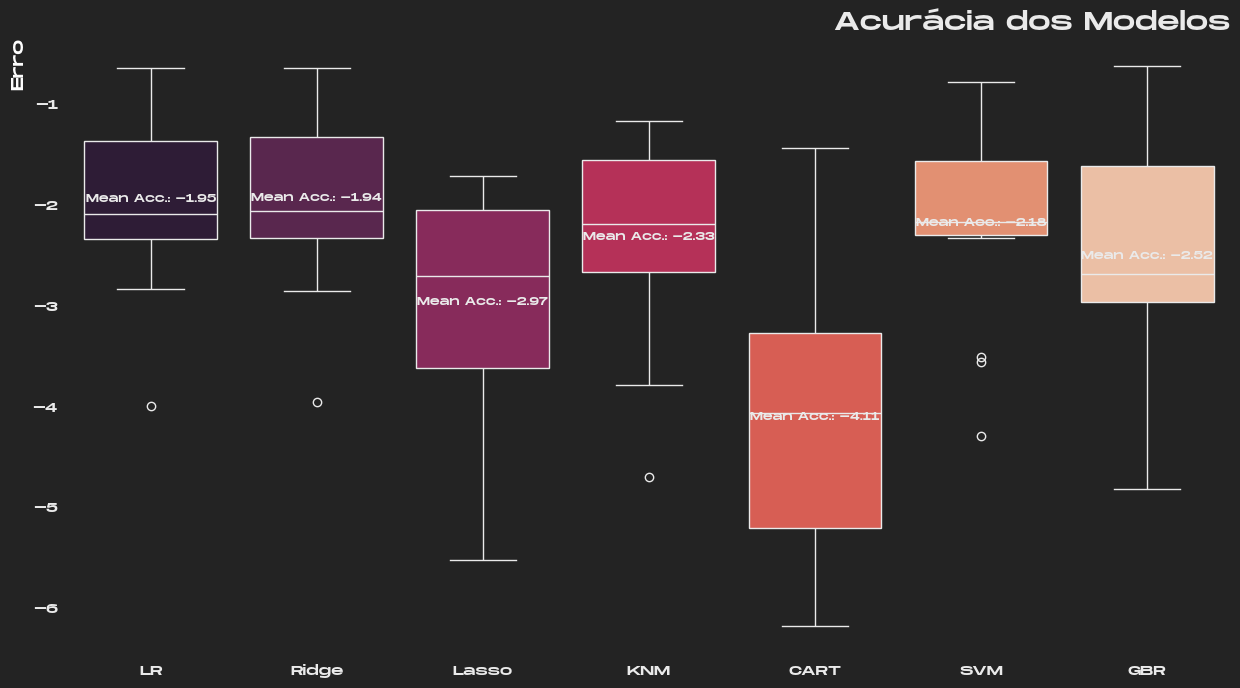

In [37]:
## CONFIGURAÇÃO DA FONTE UTILIZADA NOS TEXTOS
response = requests.get('https://github.com/fersondahl/PUC_DScience_sprint1/raw/main/Monument%20Extended.otf')

with open("/content/monument extended.otf", 'wb') as font_file:
  font_file.write(response.content)

title_font = fm.FontProperties(fname="/content/monument extended.otf")


with sns.axes_style({'axes.facecolor': '#232323', 'figure.facecolor': '#232323',
    'axes.edgecolor': '#232323', 'xtick.bottom': False, 'xtick.top': False,
    'ytick.left': False, 'ytick.right': False}):

    fig, ax = plt.subplots()

    ## BOXPLOT DA ACURÁCIA DOS MODELOS
    sns.boxplot(pd.DataFrame(results), palette='rocket', linecolor='#EAEAEA')


    ## FORMATAÇÃO DOS RÓTULOS DOS EIXOS
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_font(title_font)
        label.set_color('#EAEAEA')

    for ind, label in enumerate(ax.get_yticklabels()):
        label.set_font(title_font)
        label.set_color('#EAEAEA')

    ax.set_title('Acurácia dos Modelos', font=title_font, size=18, color='#EAEAEA', loc='right')

    ax.set_ylabel('Erro', loc='top', font=title_font, color='#fff', size=12)


    ## RÓTULO DA ACURÁCIA MÉDIA DE CADA MODELO
    for model, media in results_scores.iterrows():
        ax.annotate(text="Mean Acc.: " + str(round(media['mean'], 2)), xy=(model, media['mean']),
                    ha='center', va='center', fontproperties=title_font, color='#EAEAEA', size=8)

    fig.set_figheight(8, forward=True)
    fig.set_figwidth(15, forward=True)

> Por fim foi escolhido o modelo *Support Vector Machine*. Por mais que a Regressão Linear Múltipla e a Regressão com regularização Ridge tenham obtido melhores médias de acurácia, ainda que próximas ao modelo escolhido, percebe-se menor variabilidade no model SVM.

In [38]:
## INSTANCIAÇÃO DO MODELO ESCOLHIDO
model = LinearSVR(random_state=7)

svm = model.fit(pre_processing_routine(x_train), y_train)

mse = mean_squared_error(y_test, svm.predict(pre_processing_routine(x_test)))

mse, np.sqrt(abs(mse))

(1.3507210990273215, 1.1622052740490045)

#4. Resultados

> O modelo gerado podere ser utilizado para o monitoramento dos jogadores atuantes no brasileiro de 2024, de maneira que se possa acompanhar o surgimento de novos oportunidades de negócio.

> A predição de valor pode servir como uma importante ferramenta de estratégia de negociação ao se propor uma nova contratação. Além do mapeamento de oportunidades de mercado, os *scouts* já poderiam sugerir um valor alvo ao dirigente executivo para as tratativas.

> O modelo ainda persiste com um erro médio alto. É evidente que ainda possam ser feitas melhorias na modelagem que diminuam os desvios, contudo entende-se que a tarefa de precificação de jogadores de alto nível não é uma tarefa simples. Além do mais, aqui são considerados apenas fatores estatísticos de desempenho, sabendo que a valoração também depende de critérios subjetivos como a expectativa de desenvolvimento do jogador.

##4.1 Reaplicação do modelo

> O próprio modelo gerado foi implementada nas base de dados dos jogadores selecionados do Brasileirão 2023. O objetivo aqui é entender os principais descolamentos entre o valor de mercado Sofascore e predição gerada pelas estatísticas.

> Dessa maneira, será possível separar um grupo de jogadores com índicios semlhantes de que desempenharam abaixo do esperado em relação ao seu valor, e aqueles que desempenharam mais do que estão avaliados; O último caso apresenta-se justamente a distribuição de oportunidades de mercado a serem consideradas.

In [39]:
## REPLICAÇÃO DO MODELO NA BASE DE DADOS

model_result = pd.DataFrame(svm.predict(pre_processing_routine(alvo[selected_features])), index=alvo.index, columns=['predict'])


eval_result = pd.merge(left=model_result, right=cmp_stats[['player', 'value_M', 'equipe']], left_index=True, right_index=True, how='left')

## DIFERENÇA ENTRE A PREDIÇÃO E O VALOR REAL
eval_result['erro'] = eval_result['predict'] - eval_result['value_M']

eval_result = eval_result.sort_values('erro').reset_index(drop=True)

> Uma opção de aplicação foi separa os jogadores em dois grupos:
> 1. Supervalorizados: O grupo de 15% de jogadores em que o valor de mercado excede o valor predito de maneira mais acentuada;
> 2. Subvalorizados: O grupo de 15% de jogadores em que o valor predito excede o valor de mercado de maneira mais acentuada.

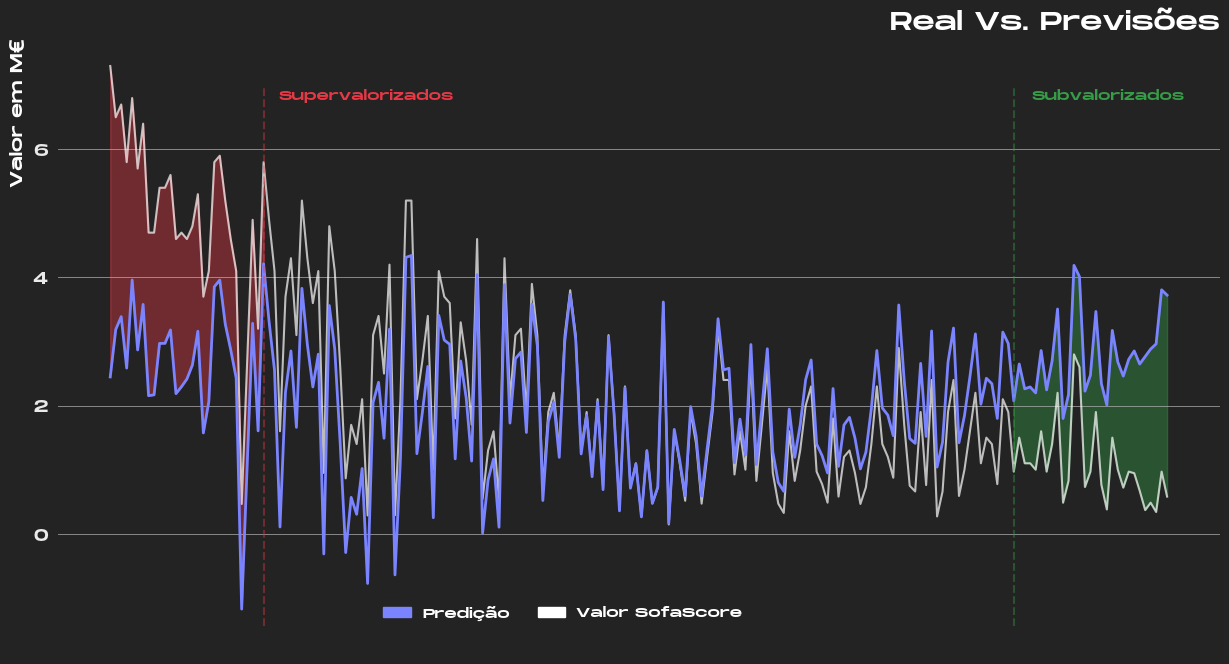

In [40]:
## CORTE DE DISTRIBUIÇÃO DE JOGADORES SUPERVALORIZADOS
lower_analysis = max(eval_result[eval_result['erro'] <= np.quantile(eval_result['erro'], .15)].index)

## CORTE DE DISTRIBUIÇÃO DE JOGADORES SUBERVALORIZADOS
upper_analysis = min(eval_result[eval_result['erro'] >= np.quantile(eval_result['erro'], .85)].index)


with sns.axes_style({'axes.facecolor': '#232323', 'figure.facecolor': '#232323',
    'axes.edgecolor': '#232323', 'xtick.bottom': False, 'xtick.top': False,
    'ytick.left': False, 'ytick.right': False}):

    fig, ax = plt.subplots()
    ax.grid(axis='y', linewidth=.5, zorder=-1)

    ## PLOT VALOR SOFASCORE
    sns.lineplot(data=eval_result, x=eval_result.index, y='value_M', color='#fff', alpha=.7)
    ## PLOT VALOR PREDIÇÃO
    sns.lineplot(data=eval_result, x=eval_result.index, y='predict', color='#7A84FF', linewidth=2)

    ax.set_xticklabels([])
    ax.set_xlabel('')

    for ind, label in enumerate(ax.get_yticklabels()):
        label.set_font(title_font)
        label.set_size(12)
        label.set_color("#EAEAEA")

    ax.set_ylabel('Valor em M€', loc='top', font=title_font, color='#fff', size=12)
    ax.set_title('Real Vs. Previsões', font=title_font, color='#fff', size=18, loc='right')

    limits = list(map(lambda elem: elem*.9, ax.get_ylim()))

    ## PLOT CORTE SUPERVALORIZADOS
    plt.vlines(x=lower_analysis, ymin=min(limits), ymax=max(limits),
               alpha=.4, linestyle='--', color="#E63946")
    ax.annotate(text='Supervalorizados', xy=(lower_analysis*1.1, max(limits)),
                ha='left', va='top', color='#E63946', font=title_font)

    ax.fill_between(x=eval_result.index, y1=eval_result['value_M'], y2=eval_result['predict'], color='#E63946',
                    where=eval_result.index<=lower_analysis, alpha=.4)


    ## PLOT CORTE SUBVALORIZADOS
    plt.vlines(x=upper_analysis, ymin=min(limits), ymax=max(limits),
               alpha=.4, linestyle='--', color="#369c47")
    ax.annotate(text='Subvalorizados', xy=(upper_analysis*1.02, max(limits)),
                ha='left', va='top', color='#369c47', font=title_font)

    ax.fill_between(x=eval_result.index, y1=eval_result['value_M'], y2=eval_result['predict'], color='#369c47',
                    where=eval_result.index>=upper_analysis, alpha=.4)


    ax.legend(handles=[Patch(label='Predição', color='#7A84FF'), Patch(label='Valor SofaScore', color='#fff')],
              frameon=False, bbox_to_anchor=(.6, 0.1), labelcolor='#fff', prop=title_font, ncols=2)


    fig.set_figheight(8, forward=True)
    fig.set_figwidth(15, forward=True)

## 4.2 Supervalorizados

> Avaliando os jogadores selecionados como atletas supervalorizados é possível perceber uma alta consistência do modelo em explicitar jogadores que, em uma análise opinativa, renderam abaixo do esperado. Casos destacáveis de:
> 1. Leonardo Fernández
> 2. Pedrinho
> 3. Thiago Maia
> 4. Wesley
> 5. Bruno Praxedes

> Alguns casos sugerem que a valorização extrema de alguns jogadores seja motivo pelo qual os tornem um mal negócio, caso como o do Luís Henrique. Por mais que não tenha tido desempenho tão abaixo pode ser definido como um jogador caro.

> Ao analisar os jogadores do grupo, entende-se também que há uma oportunidade de melhoria da modelagem ao se levar em consideração a concorrência interna que os jogadores disputam no seu clube. De alguma maneira, deve-se futuramente pesar o elenco em que o jogador faz parte dentro da regressão.
> 1. O maior destaque para esse ocorrência talvez seja o John Kennedy, que tem sua minutagem, em consequentemente suas estatísticas, abreviadas pelo fato do $_{fluminense}$ ter um dos principais jogadores da posição como titular (German cano).
> 2. Zé Rafael, Erick Pulgar e Luiz Araújo são outros exemplos de jogadores que podem ter suas estatísticas reduzidas por fazerem parte dos principais elencos do país.

In [41]:
eval_result.iloc[:lower_analysis]

,predict,player,value_M,equipe,erro
0,2.447605,Leonardo Fernández,7.300,Fluminense,-4.852395
1,3.187184,Luís Henrique,6.500,Botafogo,-3.312816
2,3.388430,Thiago Borbas,6.700,Red Bull Bragantino,-3.311570
3,2.585415,Pedrinho,5.800,Atlético Mineiro,-3.214585
4,3.961058,John Kennedy,6.800,Fluminense,-2.838942
5,2.868843,Thiago Maia,5.700,Flamengo,-2.831157
6,3.579640,Pedro,6.400,Corinthians,-2.820360
7,2.154650,Zé Rafael,4.700,Palmeiras,-2.545350
8,2.168174,Fabinho,4.700,Palmeiras,-2.531826
9,2.970840,Wesley,5.400,Cruzeiro,-2.429160


## 4.3 Subvalorizados

> Aqui está o grupo que representa as oportunidades de mercado geradas pelo modelo. Jogadores com um custo não representativo em relação a sua produção em campo.

> Percebe-se uma quantidade expressiva de jogadores de equipes de menor expressão, como o América Minero, Cuiabá, Coritiba e Goiás; Inclusive sendo 3 dos 4 clubes rebaixados. Há de se pesar o ponto já mencionado dos jogadores desses clube sofrerem menor concorrência interna no elenco. Contudo, os jogadores que estão nos principais clubes do país em geral são mais valorizados, sendo fator que também ajuda a explicar a occorência. Esse último caso, não traz imposições para a modificação do modelo, apenas clarificam o curso natural das principais equipes de buscarem melhores condições de negócios nos destaques de clubes de menor poderio financeiro.

> Ademais, faz se destaque aos jogadores: **Paulinho Paula**, que chegou como um nome sem peso e foi fundamental para a campanha de permanência do **Vasco da Gama**, e casos como os de Ganso e Lucas Silva, que apesar da idade e baixa valorização no mercado, seguem rendendo muitos frutos aos seus clubes.

In [42]:
eval_result.iloc[upper_analysis:]

,predict,player,value_M,equipe,erro
165,2.074371,Deyverson,0.970,Cuiabá,1.104371
166,2.649472,Martín Benítez,1.500,América Mineiro,1.149472
167,2.261892,André Henrique,1.100,Grêmio,1.161892
168,2.291484,Juan,1.100,São Paulo,1.191484
169,2.197630,Steven Mendoza,1.000,Santos,1.197630
170,2.860027,Zé Gabriel,1.600,Vasco da Gama,1.260027
171,2.245768,Dieguinho,0.970,Goiás,1.275768
172,2.694863,Vítor Jacaré,1.400,Bahia,1.294863
173,3.507774,Hulk,2.200,Atlético Mineiro,1.307774
174,1.798627,Derik Lacerda,0.485,Cuiabá,1.313627
